# Image Registration

In this lab exercise, you will look at image registration using hand-picked selected features.

You are asked to write a short (no more than 2 pages) report of your work, answering specific questions, and showing example images. This work is not assessed (it will not count towards your module mark) but you will get formative feedback. 

In this exercise, we will be performing image registration on two different views of a fish embryo. To achieve the following steps need to be taken:

- Load in the two images:
    - fish-vis.tif (transmission image, visible light)
    - fish-cfp-#.tif (the floating image that is to be registered to the base image. This is a grey-level version of a fluorescence image with Cyan Fluorescent Protein - CFP)

- Use the existing skeleton code to find matching key points across the two images.
    - This may involve some trial and error of manually entering coordinates and updating the figure

- Perform transformation estimation using the estimated keypoints
- Register the two images using a warp function
- Display an overlayed image (blue and red) 

Example of overlay: example.png

![Example image](example.png)

In [21]:

from skimage import io
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np

# Load Images

img_vis = io.imread("FishImageFiles/fish-vis.tif") # replace None
img_cfp = io.imread("FishImageFiles/fish-cfp-7.tif")


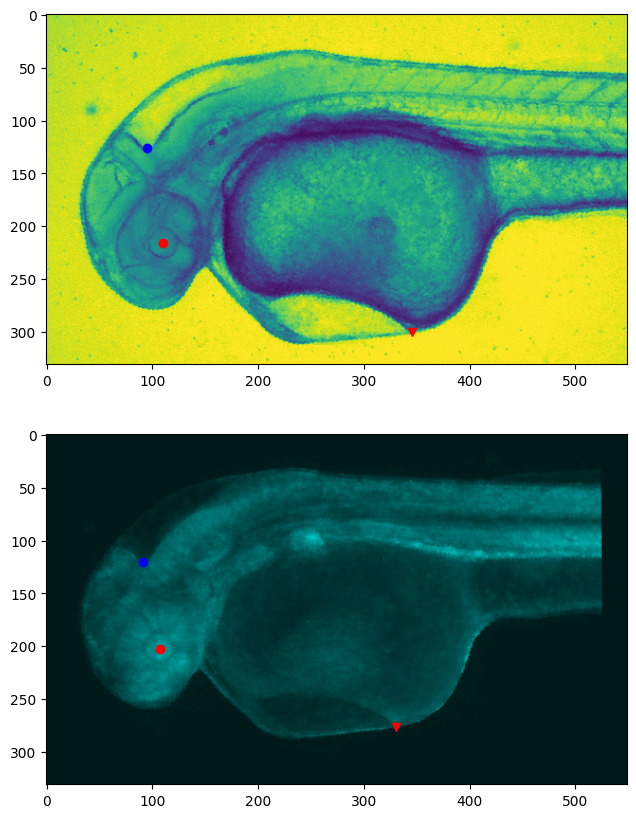

In [22]:
def show_save_image(image, title=None):
    plt.imshow(image)
    
    plt.xticks([])
    plt.yticks([])
    
    if title is not None:
        plt.title(title)
        plt.savefig(f"output/{title}.png", dpi=300, bbox_inches="tight")
        
    plt.show()

## Extract Keypoints

fig,axes = plt.subplots(2, 1,figsize=(10, 10))

#Fill in the key points array in the form as follows [[x1,y1],[x2,y2],[x3,y3]]
keypointsA = [[110, 216], [95, 126], [346, 300]]
keypointsB = [[107, 203], [91, 120], [330, 276]]

# Display the key points
symbols = ['ro','bo','rv','bv','r+','b+']
ax = axes.ravel()

for i in range(0,len(keypointsA)):
    ax[0].plot(keypointsA[i][0],keypointsA[i][1],symbols[i])
for i in range(0,len(keypointsB)):    
    ax[1].plot(keypointsB[i][0],keypointsB[i][1],symbols[i])

ax[0].imshow(img_vis)
ax[1].imshow(img_cfp)
plt.savefig(f"output/3keypoints.png", dpi=300, bbox_inches="tight")

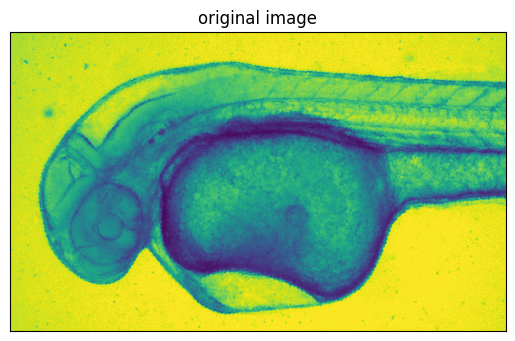

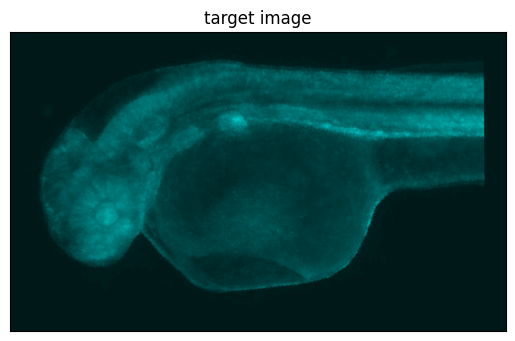

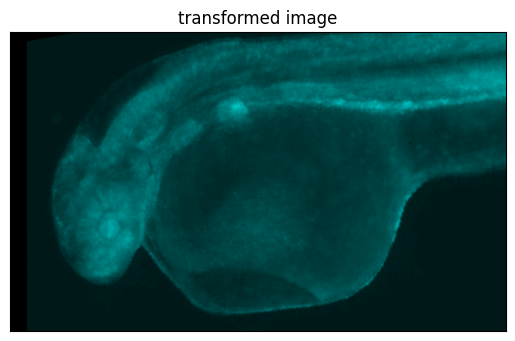

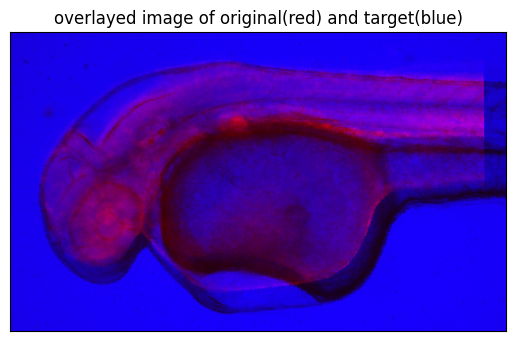

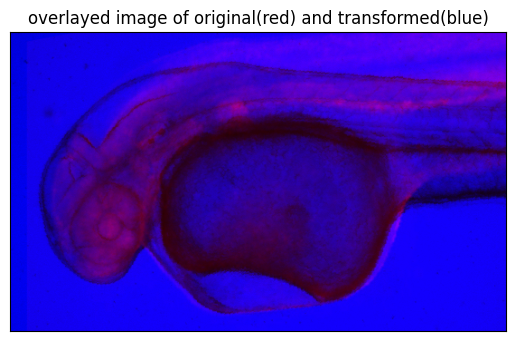

In [23]:
# Estimate the transform: https://scikit-image.org/docs/stable/auto_examples/registration/plot_opticalflow.html#sphx-glr-auto-examples-registration-plot-opticalflow-py
from skimage.transform import ProjectiveTransform, warp
from skimage.color import rgb2gray

src = np.array(keypointsA)
dst = np.array(keypointsB)

transform = ProjectiveTransform()
transform.estimate(src, dst)

warped_image = warp(img_cfp, inverse_map = transform, output_shape = img_vis.shape)

titles = ["original image", "target image", "transformed image"]
imgs = [img_vis, img_cfp, warped_image]

for i in range(0, 3):
    show_save_image(imgs[i], title=titles[i])

def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return (img - min_val) / (max_val - min_val)

# Create the overlayed images: https://scikit-image.org/docs/stable/auto_examples/registration/plot_opticalflow.html#sphx-glr-auto-examples-registration-plot-opticalflow-py
img_vis = normalize_image(img_vis)
img_cfp = normalize_image(img_cfp)

nr, nc = img_vis.shape
overlay_img_original = np.zeros((nr, nc, 3))
overlay_img_transformed = np.zeros((nr, nc, 3))

img_cfp_gray = rgb2gray(img_cfp)
warped_image_gray = rgb2gray(warped_image)

overlay_img_original[... , 0] = img_cfp_gray
overlay_img_original[... , 2] = img_vis

overlay_img_transformed[... , 0] = warped_image_gray
overlay_img_transformed[... , 2] = img_vis

overlay_imgs = [overlay_img_original, overlay_img_transformed]
overlay_titles = ["overlayed image of original(red) and target(blue)", "overlayed image of original(red) and transformed(blue)"]
for i in range(0, 2):
    show_save_image(overlay_imgs[i], title=overlay_titles[i])

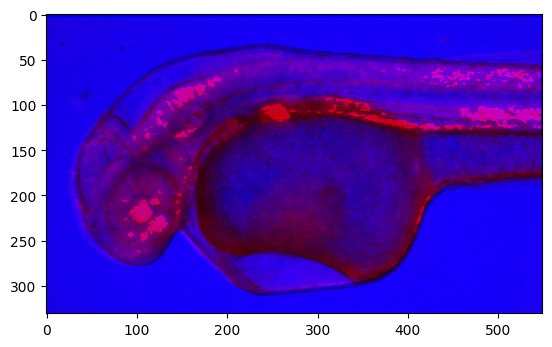

In [40]:
import cv2

overlay_img_vis = np.zeros((nr, nc, 3))

img_cfp_pro = io.imread("original_processed.png")
img_cfp_pro = img_cfp_pro[:, :, :3]
img_cfp_pro_gray = rgb2gray(img_cfp_pro)

img_cfp_pro_gray = cv2.resize(img_cfp_pro_gray, (img_vis.shape[1], img_vis.shape[0]))

overlay_img_vis[... , 0] = img_cfp_pro_gray
overlay_img_vis[... , 2] = img_vis

plt.imshow(overlay_img_vis)
plt.show()

In [45]:
from skimage.metrics import mean_squared_error

mse_value_transformed = mean_squared_error(overlay_img_transformed, overlay_img_vis)
print(f"MSE Value (Transformed): {mse_value_transformed:.4f}")

MSE Value (Transformed): 0.0060


In [46]:
from skimage.metrics import structural_similarity as ssim

min_size = min(overlay_img_transformed.shape[0], overlay_img_transformed.shape[1])
win_size = min(7, min_size)

ssim_value_transformed, _ = ssim(
    overlay_img_transformed, 
    overlay_img_vis, 
    full=True, 
    data_range=1, 
    win_size=win_size, 
    channel_axis=-1
)

print(f"SSIM Value (Transformed): {ssim_value_transformed:.4f}")

SSIM Value (Transformed): 0.8623


In [47]:
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_value = psnr(overlay_img_transformed, overlay_img_vis, data_range=1)
print(f"PSNR Value (Transformed): {psnr_value:.4f}")

PSNR Value (Transformed): 22.2234


##### Question 1: What is the effect of increasing/decreasing the number of chosen control points in registration accuracy?

##### Question 2: How would you evaluate the accuracy of your registration?